# Employee Retention recommendations
## Léa Zurfluh - Dec 2021


#### <font color = 'blue'> Get the data </font>

In [1]:
### IMPORTS ###
import pandas as pd
import numpy as np
import math
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, precision_recall_curve
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
# Random Forests
from sklearn.ensemble import RandomForestClassifier

### VARIABLES ###
FILE = 'qs_employee_retention.csv'

In [2]:
# Store data set in dataframe
df = pd.read_csv(FILE)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


#### <font color = 'blue'> KNN algorithm </font>

In [3]:
# Data preprocessing:
# 1. Scale nb projects per year of tenure
df['projects_year'] = df['number_project']/df['time_spend_company'] 

# 2. Make salary an ordinal variable
sal = {'low':0, 'medium':1, 'high':2}
df.salary = df.salary.map(sal)

The KNN algorithm is based on distance, hence we need to scale our features.

In [4]:
# Let's define the type of our variables first.
# DataFrame that has the name of the feature and the number of unique values:
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
satisfaction_level,92
last_evaluation,65
number_project,6
average_montly_hours,215
time_spend_company,8
Work_accident,2
left,2
promotion_last_5years,2
sales,10


In [5]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
lb, le = LabelBinarizer(), LabelEncoder()

In [6]:
round(df['salary'].describe(),1)

count    14999.0
mean         0.6
std          0.6
min          0.0
25%          0.0
50%          1.0
75%          1.0
max          2.0
Name: salary, dtype: float64

In [7]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,projects_year
0,0.38,0.53,2,157,3,0,1,0,sales,0,0.666667
1,0.80,0.86,5,262,6,0,1,0,sales,1,0.833333
2,0.11,0.88,7,272,4,0,1,0,sales,1,1.750000
3,0.72,0.87,5,223,5,0,1,0,sales,0,1.000000
4,0.37,0.52,2,159,3,0,1,0,sales,0,0.666667


Let's drop some columns:
* The department had no link with the fact that an employee leaves or stays
* We have created a variable 'projects/year' to scale the total nb of projects an employee has worked on by their tenure in the company, so we don't need the initial column

In [8]:
df.drop('sales', axis=1, inplace=True)

In [9]:
df.drop('number_project', axis=1, inplace=True)

In [10]:
# Checking all dimensions are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
salary                   14999 non-null int64
projects_year            14999 non-null float64
dtypes: float64(3), int64(6)
memory usage: 1.0 MB


Scale the features

In [11]:
mm = MinMaxScaler()
for column in df.columns:
    df[column] = mm.fit_transform(df[[column]])

#round(df.describe().T, 3)

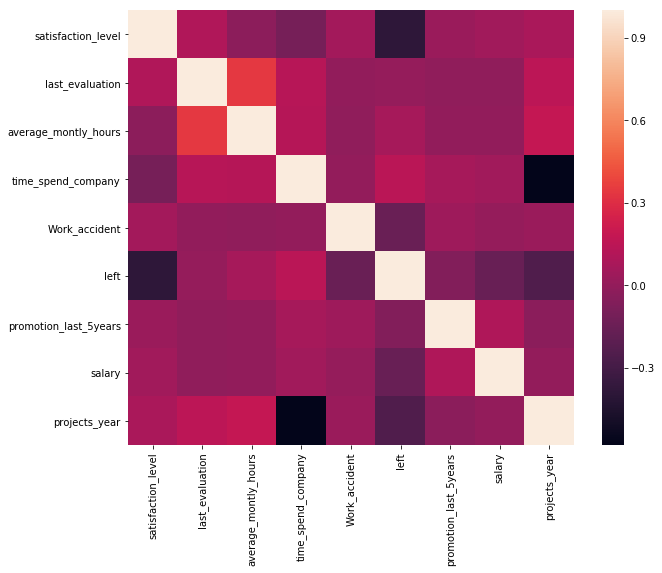

In [12]:
# Now that all variables are encoded and scaled, let's take a look at the correlation matrix
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(df.corr());

Now let's run a KNN model with hyperparameter tuning in order to find the best K leading to the highest Recall score.
Indeed in this situation it is better to predict that people will leave although they ultimately stay, rather than not predict that someone will leave (although they ultimately do). 

In [26]:
# Set up X and y variables
y, X = df['left'], df.drop(columns='left')
# Split the data into training and test samples
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.3, random_state=7879) #K-Nearest Neighbors
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.3, random_state=7879) #Random Forests


In [20]:
# Hyperparameter tuning - identify the best K
max_k = 30
recall_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train_knn, y_train_knn)
    
    y_pred_knn = knn.predict(X_test_knn)
    recall = recall_score(y_pred_knn, y_test_knn)
    recall_scores.append((k, round(recall_score(y_test_knn, y_pred_knn), 4)))
    error = 1-round(accuracy_score(y_test_knn, y_pred_knn), 4)
    error_rates.append((k, error))
    
recall_results = pd.DataFrame(recall_scores, columns=['K', 'Recall Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

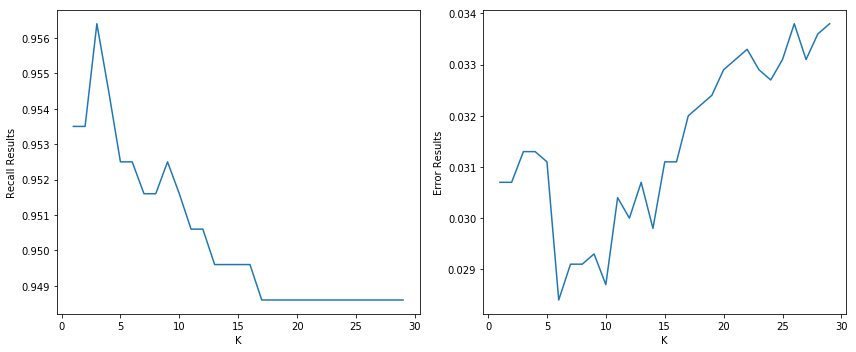

In [21]:
# Plotting Recall and Error Rate for each K
metrics = [recall_results, error_results]
metrics_names = ['Recall Results', 'Error Results']
fig, axes = plt.subplots(1, 2,figsize=(12,5))

for i, (ax, metric) in enumerate(zip(axes.flatten(), metrics)):
    ax.plot(metric.set_index('K'))
    ax.set(xlabel='K', ylabel=metrics_names[i])
    ax.set_xticks(range(0, max_k+1, 5))
    plt.tight_layout();

In [27]:
# Confirming what we see visually by finding the highest Recall and lowest error:
max_recall = recall_results['Recall Score'].max()
best_k_recall = min(recall_results[recall_results['Recall Score'] == max_recall]['K'])
print('The highest Recall is {:.2f} for K ={}'.format(max_recall, best_k_recall))

min_error = error_results['Error Rate'].min()
best_k_err = min(error_results[error_results['Error Rate'] == min_error]['K'])
print('The lowest error is {:.2f} for K ={}'.format(min_error, best_k_err))

best_k = best_k_recall

The highest Recall is 0.96 for K =3
The lowest error is 0.03 for K =6


Because we want a higher recall, let's take K=3.


In [24]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=int(best_k))
knn = knn.fit(X_train_knn, y_train_knn)
y_pred_knn = knn.predict(X_test_knn)
# Precision, recall, f-score from the multi-class support function
print(classification_report(y_test_knn, y_pred_knn))
print('Accuracy score: ', round(accuracy_score(y_test_knn, y_pred_knn), 2))
print('Recall score: ', round(recall_score(y_test_knn, y_pred_knn), 2))
print('Precision score: ', round(precision_score(y_test_knn, y_pred_knn), 3))
print('F1 Score: ', round(f1_score(y_test_knn, y_pred_knn), 2))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      3468
         1.0       0.90      0.94      0.92      1032

    accuracy                           0.96      4500
   macro avg       0.94      0.95      0.95      4500
weighted avg       0.96      0.96      0.96      4500

Accuracy score:  0.96
Recall score:  0.94
Precision score:  0.898
F1 Score:  0.92


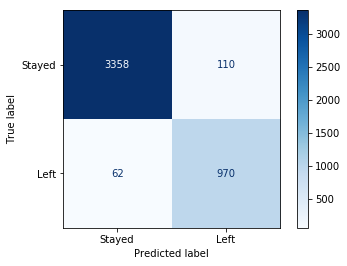

In [25]:
# Plot confusion matrix
plot_confusion_matrix(knn, X_test_knn, y_test_knn,
                                 display_labels=['Stayed', 'Left'],
                                 cmap=plt.cm.Blues,
                                 #normalize='true'
                     );


In [28]:
len(df)

14999

The confusion matrix shows indeed we have tuned our K to favour Recall: it minimised the number of false negatives (when we predicted 'stayed' although they left) vs. the number of false positives (when we predicted 'left' altough they stayed).


#### <font color = 'blue'>Random Forest </font>

Lets run a Random Forest algorithm for different number of trees, and plot its out of bag ('oob') error. The number of trees leading to the lowest oob error will then be taken as the best one for this analysis.

In [28]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

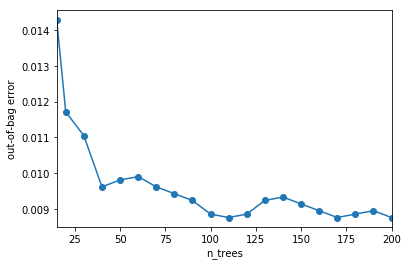

In [29]:
# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, 
                            random_state=7879, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()
tree_list = [15, 20, 30, 40, 50, 60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

# Iterate through all of the possibilities for 
# number of trees
for n_trees in tree_list:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train_rf, y_train_rf)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error');

The best number of trees seems to be 110, let's keep this value for the next part.

In [30]:
# Random forest with 110 estimators
model = RF.set_params(n_estimators=110)
y_pred_rf = model.predict(X_test_rf)

cr = classification_report(y_test_rf, y_pred_rf)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test_rf, y_pred_rf),
                         'precision': precision_score(y_test_rf, y_pred_rf),
                         'recall': recall_score(y_test_rf, y_pred_rf),
                         'f1': f1_score(y_test_rf, y_pred_rf),
                         'auc': roc_auc_score(y_test_rf, y_pred_rf)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3468
         1.0       0.99      0.95      0.97      1032

    accuracy                           0.99      4500
   macro avg       0.99      0.98      0.98      4500
weighted avg       0.99      0.99      0.99      4500

   accuracy  precision    recall        f1       auc
0     0.988   0.993939  0.953488  0.973294  0.975879


Recall is slightly better for random forests (95%) than for KNN (94%).

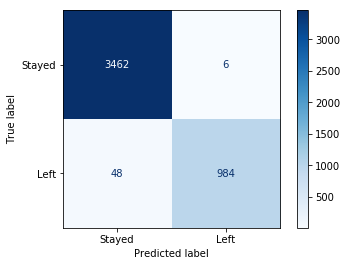

In [31]:
# Plot confusion matrix
plot_confusion_matrix(model, X_test_rf, y_test_rf,
                                 display_labels=['Stayed', 'Left'],
                                 cmap=plt.cm.Blues,
                                 #normalize='true'
                     );

However, the confusion matrix is way better for random forests as there are twice as few false negatives.

#### <font color = 'blue'> Feature importance </font>

Let's now look at the importance of each feature in our random forest model for interpretation purposes.

In [32]:
model.feature_importances_

array([0.31940602, 0.13015749, 0.16332485, 0.19805859, 0.00997157,
       0.00122686, 0.01230705, 0.16554757])

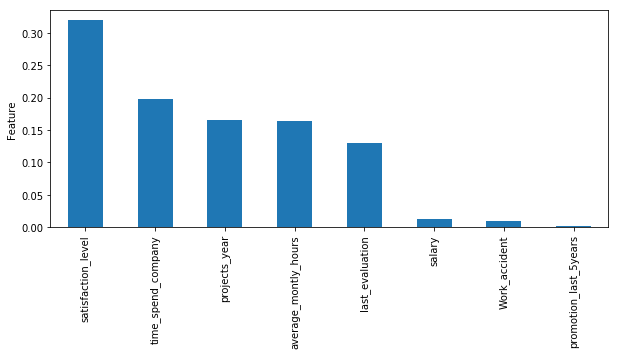

In [33]:
feature_cols = X_test_rf.columns
feature_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar', figsize=(10, 4))
ax.set(ylabel='Relative Importance');
ax.set(ylabel='Feature');

With no surprise, the feature with the highest importance is 'satisfaction_level': employees tend to leave when they are not satisfied in their job.
However, salary and promotion are in the lowest importance of this model - this will need further investigation.